In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from gym.utils import seeding
from tensorflow.keras.utils import plot_model
from world_model.networks import RNN, VAE
import world_model.base.config as config

np.set_printoptions(precision=4, suppress=True)


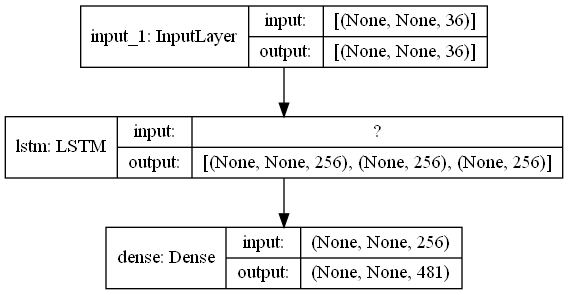

In [2]:
rnn = RNN()
rnn.save_weights(os.path.join(config.RUN_FOLDER, 'rnn/weights.h5'))

plot_model(rnn.model, to_file=os.path.join(config.RUN_FOLDER, 'rnn/model.png'), show_shapes=True)

In [3]:
vae = VAE()
vae.set_weights(os.path.join(config.RUN_FOLDER, 'vae/weights.h5'))

In [4]:
rnn_files = np.load(config.DATA_DIR + '/rnn_files.npz')
rnn_input = rnn_files['rnn_input']
rnn_output = rnn_files['rnn_output']

initial_mu = np.load(config.DATA_DIR + '/initial_z.npz')['initial_mu']
initial_log_var = np.load(config.DATA_DIR + '/initial_z.npz')['initial_log_var']

rollout_files = np.load(config.DATA_ROLLOUT_DIR + '31699541.npz')
obs_file = rollout_files['obs']
action_file = rollout_files['action']
reward_file = rollout_files['reward']
done_file = rollout_files['done']

series_files = np.load(config.DATA_SERIES_DIR + '31699541.npz')
mu_file = series_files['mu']
log_var_file = series_files['log_var']
action_2_file = series_files['action']
reward_2_file = series_files['reward']
done_2_file = series_files['done']

hot_zs = np.where(np.exp(initial_log_var[0] / 2) < 0.5)[0]
hot_zs

array([ 5, 10, 18], dtype=int64)

In [5]:
GAUSSIAN_MIXTURES = 5
Z_DIM = 32

np_random, seed = seeding.np_random()

def get_mixture_coef(z_pred):
    log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
    log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis=1, keepdims=True))
    return log_pi,  mu, log_sigma

def get_pi_idx(x, pdf):
    # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if accumulate >= x:
            return i
    random_value = np.random.randint(N)
    return random_value

def sample_z(mu, log_sigma):
    z = mu + np.exp(log_sigma) * np_random.randn(*log_sigma.shape) * 0.5
    return z

def sample_next_mdn_output(obs, h, c):
    d = GAUSSIAN_MIXTURES * Z_DIM

    out = rnn.forward.predict([np.array([[obs]]), np.array([h]), np.array([c])])
    y_pred = out[0][0][0]
    new_h = out[1][0]
    new_c = out[2][0]

    z_pred = y_pred[:3*d]
    rew_pred = y_pred[-1]
    z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)

    chosen_log_pi = np.zeros(Z_DIM)
    chosen_mu = np.zeros(Z_DIM)
    chosen_log_sigma = np.zeros(Z_DIM)

    # adjust temperatures
    pi = np.copy(log_pi)
    pi = np.exp(pi)
    pi /= pi.sum(axis=1).reshape(Z_DIM, 1)

    for j in range(Z_DIM):
        idx = get_pi_idx(np_random.rand(), pi[j])
        chosen_log_pi[j] = idx
        chosen_mu[j] = mu[j, idx]
        chosen_log_sigma[j] = log_sigma[j, idx]
    
    next_z = sample_z(chosen_mu, chosen_log_sigma)

    if rew_pred > 0:
        next_reward = 1
    else:
        next_reward = 0
    
    return next_z, chosen_mu, chosen_log_sigma, chosen_log_pi, rew_pred, next_reward, new_h, new_c


In [6]:
rnn_idx = 10
idx = 0

obs = rnn_input[rnn_idx]
actual = rnn_output[rnn_idx]

print(obs.shape)
print(actual.shape)

(299, 36)
(299, 33)


2.503223163878944


[[-0.0018]]


[1.1076 1.3417 1.409  1.0451 1.1122]


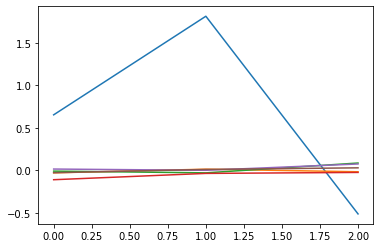

In [7]:
d = GAUSSIAN_MIXTURES * Z_DIM

print(sum(np.abs(obs[idx,hot_zs])))
plt.plot(actual[idx,hot_zs])

y_pred = rnn.model.predict(np.array([[obs[idx,:]]]))

z_pred = y_pred[:,:,:(3*d)]
rew_pred = y_pred[:,:,-1]
print(rew_pred)

z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])
log_pi, mu, log_sigma = np.split(z_pred, 3, 1)

plt.plot(mu[hot_zs])

log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))
print(sum(np.abs(mu)))


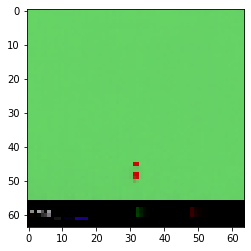

299


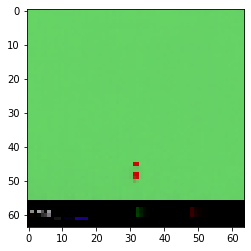

In [8]:
current_z = obs[idx]
i = idx
current_h = np.zeros(256)
current_c = np.zeros(256)

next_z = obs[idx, :]
next_h = np.zeros(256)
next_c = np.zeros(256)

# SIMULATE TURNING IN THE DREAM
for i in range(300):
    next_z, chosen_mu, chosen_log_sigma, chosen_pi, rew_pred, next_reward, next_h, next_c \
        = sample_next_mdn_output(next_z, next_h, next_c)

    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
    next_z = np.concatenate([next_z, [1, 1, 0], [next_reward]])

    plt.gca().cla()
    plt.imshow(next_z_decoded)

    print(next_reward)

    display.clear_output(wait=True)
    display.display(plt.gcf())

    print(i)


(33, 299)


<Figure size 1440x2160 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<ipython-input-9-253391427578>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(511)


<AxesSubplot:>

<ipython-input-9-253391427578>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(512)


<AxesSubplot:>

<ipython-input-9-253391427578>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(513)


<AxesSubplot:>

<ipython-input-9-253391427578>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(511)


<AxesSubplot:>

<ipython-input-9-253391427578>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(512)


<AxesSubplot:>

<ipython-input-9-253391427578>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(513)


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

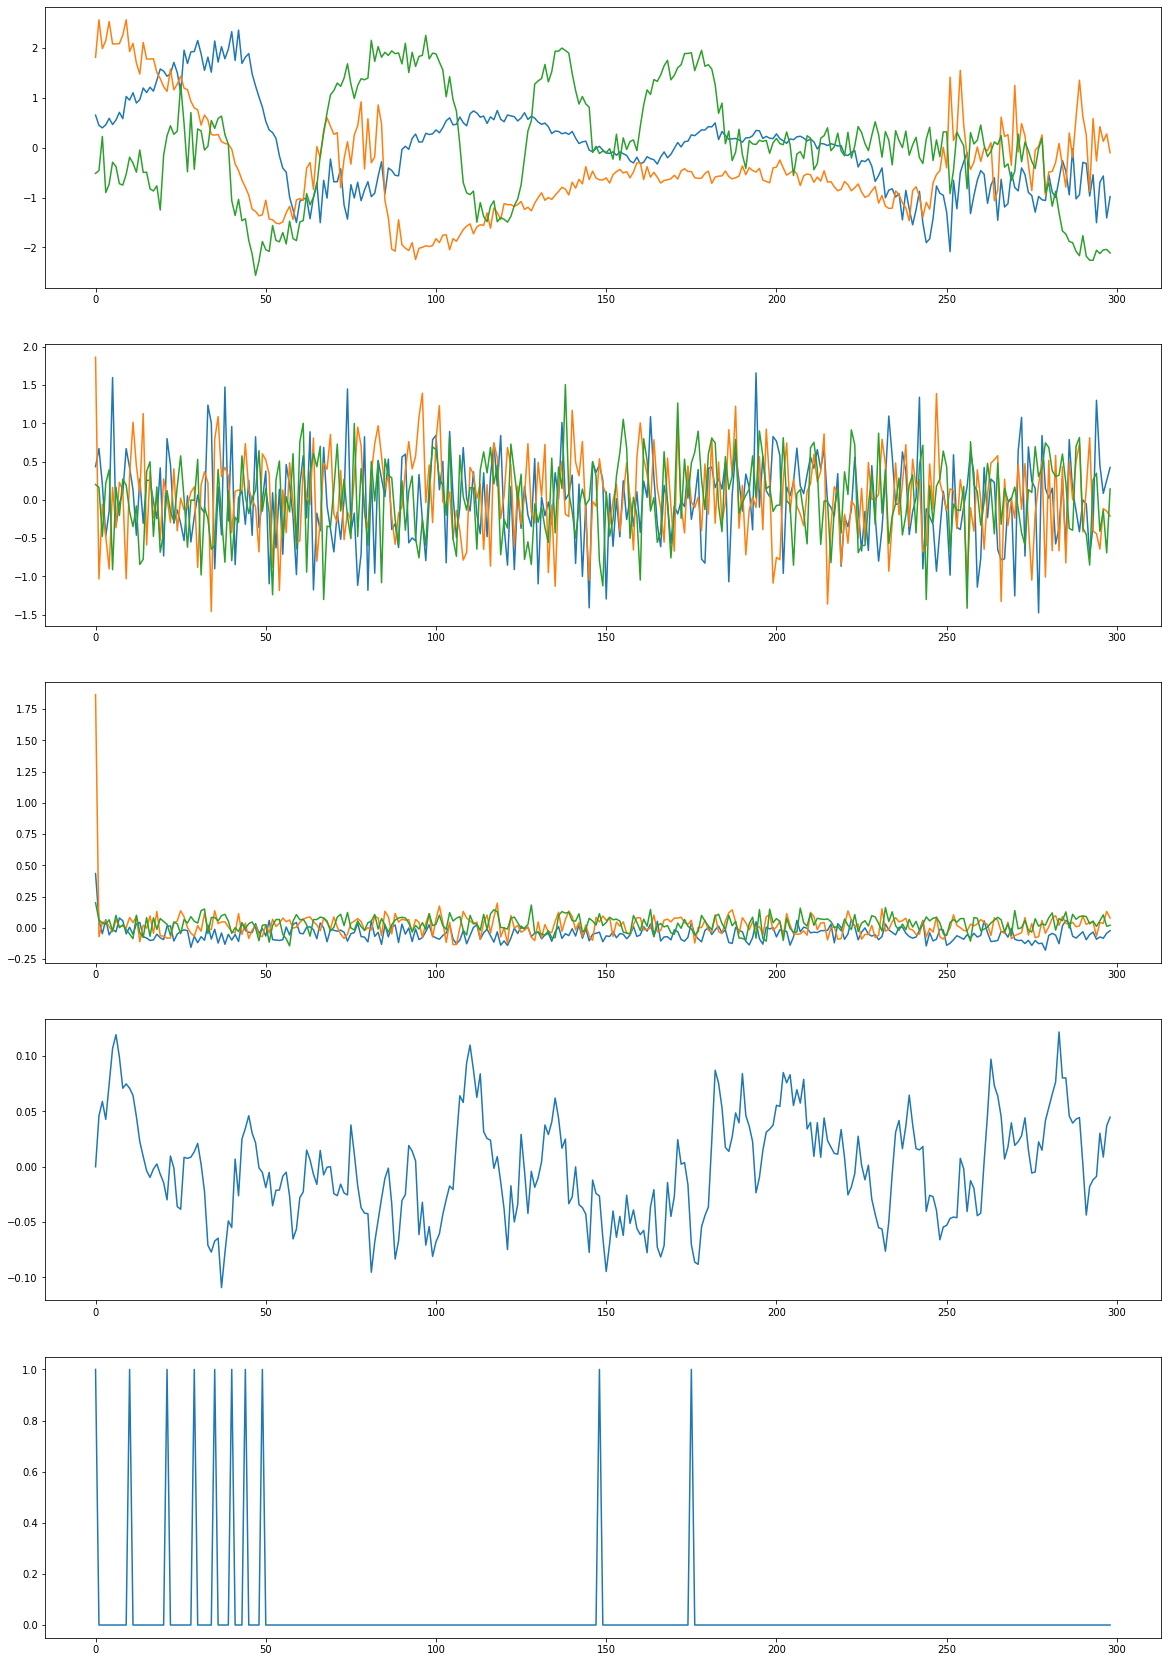

In [9]:
b = np.swapaxes(actual,0,1)
print(b.shape)
actual_rew = b[-1,:]

next_zs = np.zeros(shape = (32,299))
next_mus = np.zeros(shape = (32,299))
next_rews = np.zeros(shape = (1,299))
next_z = obs[idx,:]

next_mus[:,0] = next_z[:32]
next_zs[:,0] = next_z[:32]
next_rews[:,0] = next_z[-1]

for i in range(1,299):
    next_z, chosen_mu, chosen_log_sigma, chosen_pi, rew_pred, next_reward, next_h, next_c = sample_next_mdn_output(next_z, next_h, next_c)
    next_mus[:,i] = chosen_mu
    next_zs[:,i] = next_z
    next_rews[:,i] = rew_pred
    
    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
    
    next_z = np.concatenate([next_z, [-1,1,0], [next_reward]])

plt.figure(figsize=(20,30))
for i in hot_zs:
    plt.subplot(511)
    plt.plot( b[i,:])
    plt.subplot(512)
    plt.plot( next_zs[i,:])
    plt.subplot(513)
    plt.plot( next_mus[i,:])
    
plt.subplot(514)
plt.plot(next_rews[0,:])

plt.subplot(515)
plt.plot(actual_rew[:])
    